In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
%load_ext autoreload
%autoreload 2

from simulator.load_data import load_md_from_file
from simulator.simulator import Sim
from simulator.strategy import StoikovStrategy, BestPosStrategy, FutureMidPriceStrategy


In [37]:
md = load_md_from_file(path='md/btcusdt_Binance_LinearPerpetual/', nrows=10 ** 5)
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

delay = pd.Timedelta(0.1, 's').delta
hold_time = pd.Timedelta(10, 's').delta
gamma = 1
horizon_const = 1
intensity = 3

sim = Sim(md, latency, md_latency)
stoikov = StoikovStrategy(delay, gamma, horizon_const, intensity, hold_time)
stoikov.run(sim)


C:\Users\Rs63\AppData\Local\Temp\ipykernel_20452\2739468151.py:2: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  latency = pd.Timedelta(10, 'ms').delta
C:\Users\Rs63\AppData\Local\Temp\ipykernel_20452\2739468151.py:3: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  md_latency = pd.Timedelta(10, 'ms').delta
C:\Users\Rs63\AppData\Local\Temp\ipykernel_20452\2739468151.py:5: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  delay = pd.Timedelta(0.1, 's').delta
C:\Users\Rs63\AppData\Local\Temp\ipykernel_20452\2739468151.py:6: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  hold_time = pd.Timedelta(10, 's').delta


([OwnTrade(place_ts=1655942402250125991, exchange_ts=1655942405292000000, receive_ts=1655942405302000000, trade_id=0, order_id=1, side='ASK', size=0.001, price=19977.737682072453, execute='TRADE'),
  OwnTrade(place_ts=1655942402624789714, exchange_ts=1655942405292000000, receive_ts=1655942405302000000, trade_id=1, order_id=3, side='ASK', size=0.001, price=19977.737682072453, execute='TRADE'),
  OwnTrade(place_ts=1655942403346968722, exchange_ts=1655942405292000000, receive_ts=1655942405302000000, trade_id=2, order_id=5, side='ASK', size=0.001, price=19977.737682072453, execute='TRADE'),
  OwnTrade(place_ts=1655942404080791047, exchange_ts=1655942405292000000, receive_ts=1655942405302000000, trade_id=3, order_id=7, side='ASK', size=0.001, price=19977.737682072453, execute='TRADE'),
  OwnTrade(place_ts=1655942404452706766, exchange_ts=1655942405292000000, receive_ts=1655942405302000000, trade_id=4, order_id=9, side='ASK', size=0.001, price=19977.737682072468, execute='TRADE'),
  OwnTrade

In [8]:
sim = Sim(md, latency, md_latency)
mid_price = BestPosStrategy(delay, hold_time)
mid_price.run(sim)

([OwnTrade(place_ts=1655942402250125991, exchange_ts=1655942402623000000, receive_ts=1655942402633000000, trade_id=0, order_id=1, side='ASK', size=0.001, price=19977.5, execute='TRADE'),
  OwnTrade(place_ts=1655942402624789714, exchange_ts=1655942405292000000, receive_ts=1655942405302000000, trade_id=1, order_id=3, side='ASK', size=0.001, price=19977.5, execute='TRADE'),
  OwnTrade(place_ts=1655942403346968722, exchange_ts=1655942405292000000, receive_ts=1655942405302000000, trade_id=2, order_id=5, side='ASK', size=0.001, price=19977.5, execute='TRADE'),
  OwnTrade(place_ts=1655942404080791047, exchange_ts=1655942405292000000, receive_ts=1655942405302000000, trade_id=3, order_id=7, side='ASK', size=0.001, price=19977.5, execute='TRADE'),
  OwnTrade(place_ts=1655942404452706766, exchange_ts=1655942405292000000, receive_ts=1655942405302000000, trade_id=4, order_id=9, side='ASK', size=0.001, price=19977.5, execute='TRADE'),
  OwnTrade(place_ts=1655942404752033322, exchange_ts=165594240529

In [9]:
sim = Sim(md, latency, md_latency)
future = FutureMidPriceStrategy(delay, hold_time)
future.run(sim)

([OwnTrade(place_ts=1655942409192624075, exchange_ts=1655942409215000000, receive_ts=1655942409225000000, trade_id=16, order_id=23, side='ASK', size=0.001, price=19978.0, execute='TRADE'),
  OwnTrade(place_ts=1655942409192624075, exchange_ts=1655942409233000000, receive_ts=1655942409243000000, trade_id=17, order_id=22, side='BID', size=0.001, price=19977.9, execute='TRADE'),
  OwnTrade(place_ts=1655942409293004793, exchange_ts=1655942409307000000, receive_ts=1655942409317000000, trade_id=18, order_id=25, side='ASK', size=0.001, price=19978.0, execute='TRADE'),
  OwnTrade(place_ts=1655942409293004793, exchange_ts=1655942409316000000, receive_ts=1655942409326000000, trade_id=19, order_id=24, side='BID', size=0.001, price=19977.9, execute='TRADE'),
  OwnTrade(place_ts=1655942409622895634, exchange_ts=1655942409634000000, receive_ts=1655942409644000000, trade_id=30, order_id=31, side='ASK', size=0.001, price=19977.4, execute='TRADE'),
  OwnTrade(place_ts=1655942409622895634, exchange_ts=16

Сравним графики PnL трех стратегий:

Text(0, 0.5, 'PNL')

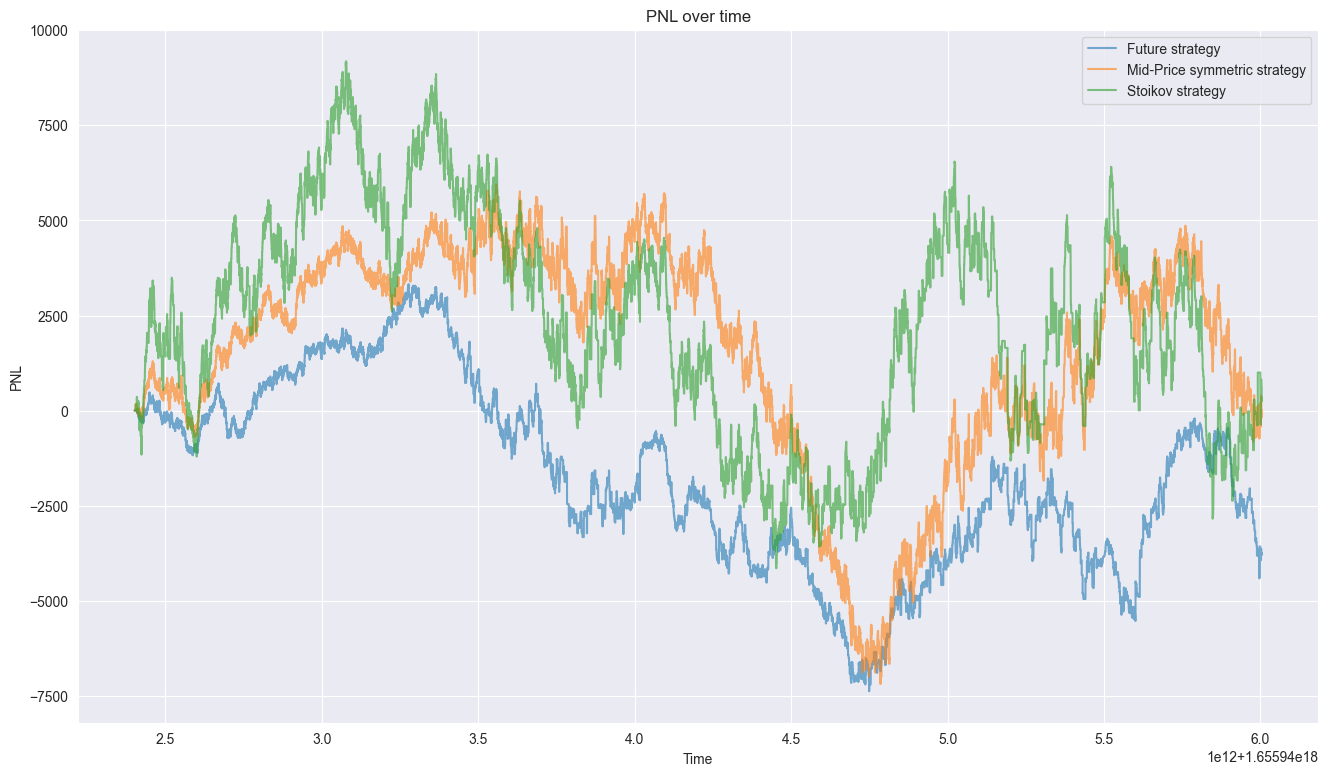

In [38]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 9))
plt.title('PNL over time')
plt.plot(future.history['time'], future.history['pnl'][1:-1], label='Future strategy', alpha=0.6)
plt.plot(mid_price.history['time'], mid_price.history['pnl'][1:], label='Mid-Price symmetric strategy',
         alpha=0.6)
plt.plot(stoikov.history['time'], stoikov.history['pnl'][1:], label='Stoikov strategy', alpha=0.6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('PNL')

In [39]:
print('Средние значения PnL:\nStoikov strategy: {}\nMid-Price strategy: {}\nFuture strategy: {}'.format(np.mean(stoikov.history['pnl'][1:]), np.mean(mid_price.history['pnl'][1:]), np.mean(future.history['pnl'][1:])))

Средние значения PnL:
Stoikov strategy: 3183.3594710907328
Mid-Price strategy: 1909.0130503520031
Future strategy: -642.5907929915177


In [40]:
print('Стандартное отклонение PnL:\nStoikov strategy: {}\nMid-Price strategy: {}\nFuture strategy: {}'.format(np.std(stoikov.history['pnl'][1:]), np.std(mid_price.history['pnl'][1:]), np.std(future.history['pnl'][1:])))

Стандартное отклонение PnL:
Stoikov strategy: 3050.4198635682046
Mid-Price strategy: 2555.0354401990066
Future strategy: 2447.653100739512


Видим, что PnL у стратегии Стойкова в среднем выше, чем у двух других стратегий. При этом стандартное отклонение у стратегии Стойкова оказалось тоже выше.

Сравним спреды стратегий:

Text(0.5, 1.0, 'Spreads')

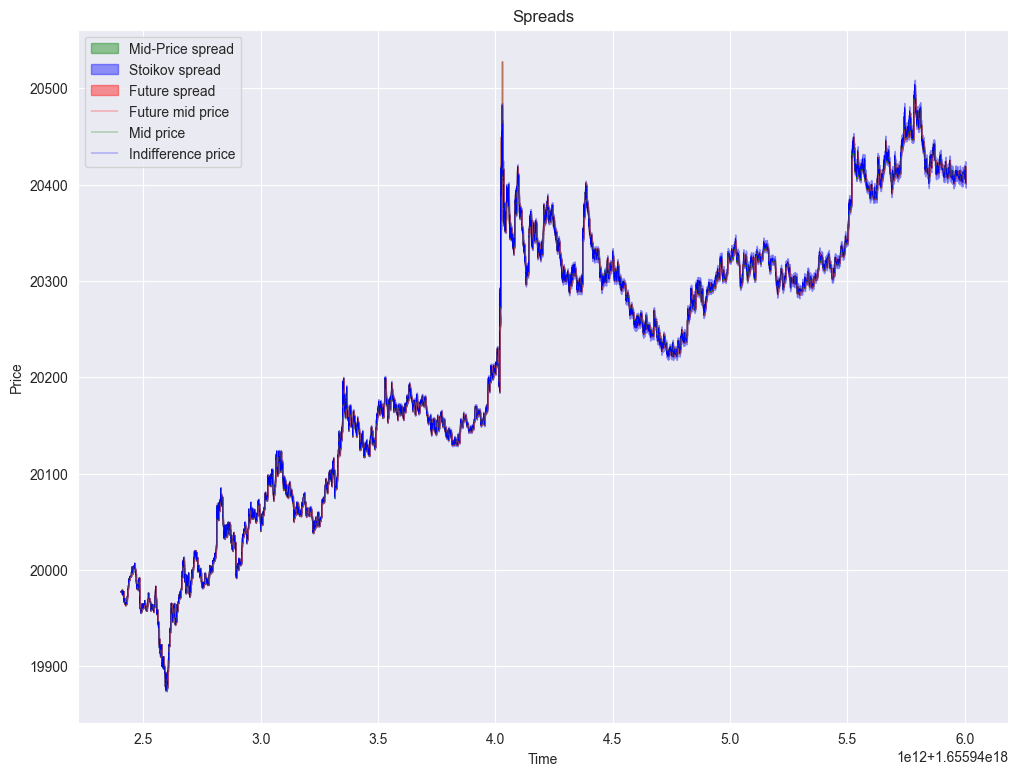

In [41]:
plt.figure(figsize=(12, 9))

plt.fill_between(mid_price.history['time'], mid_price.history['bid_price'],
                 mid_price.history['ask_price'], label='Mid-Price spread', alpha=0.4, color='green')
plt.fill_between(stoikov.history['time'], stoikov.history['bid_price'],
                 stoikov.history['ask_price'], label='Stoikov spread', alpha=0.4, color='blue')
plt.fill_between(future.history['time'], future.history['bid_price'], future.history['ask_price'],
                 label='Future spread', alpha=0.4, color='red')
plt.plot(future.history['time'], future.history['mid_price'], label='Future mid price',
         color='red', linewidth=0.3)
plt.plot(mid_price.history['time'], mid_price.history['mid_price'], label='Mid price',
         color='green', linewidth=0.3)
plt.plot(stoikov.history['time'], stoikov.history['mid_price'], label='Indifference price',
         color='blue', linewidth=0.3)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Spreads')

In [42]:
stoikov_spread = np.array(stoikov.history['ask_price']) - np.array(stoikov.history['bid_price'])
mid_spread = np.array(mid_price.history['ask_price']) - np.array(mid_price.history['bid_price'])
future_spread = np.array(future.history['ask_price']) - np.array(future.history['bid_price'])

Text(0, 0.5, 'Spread')

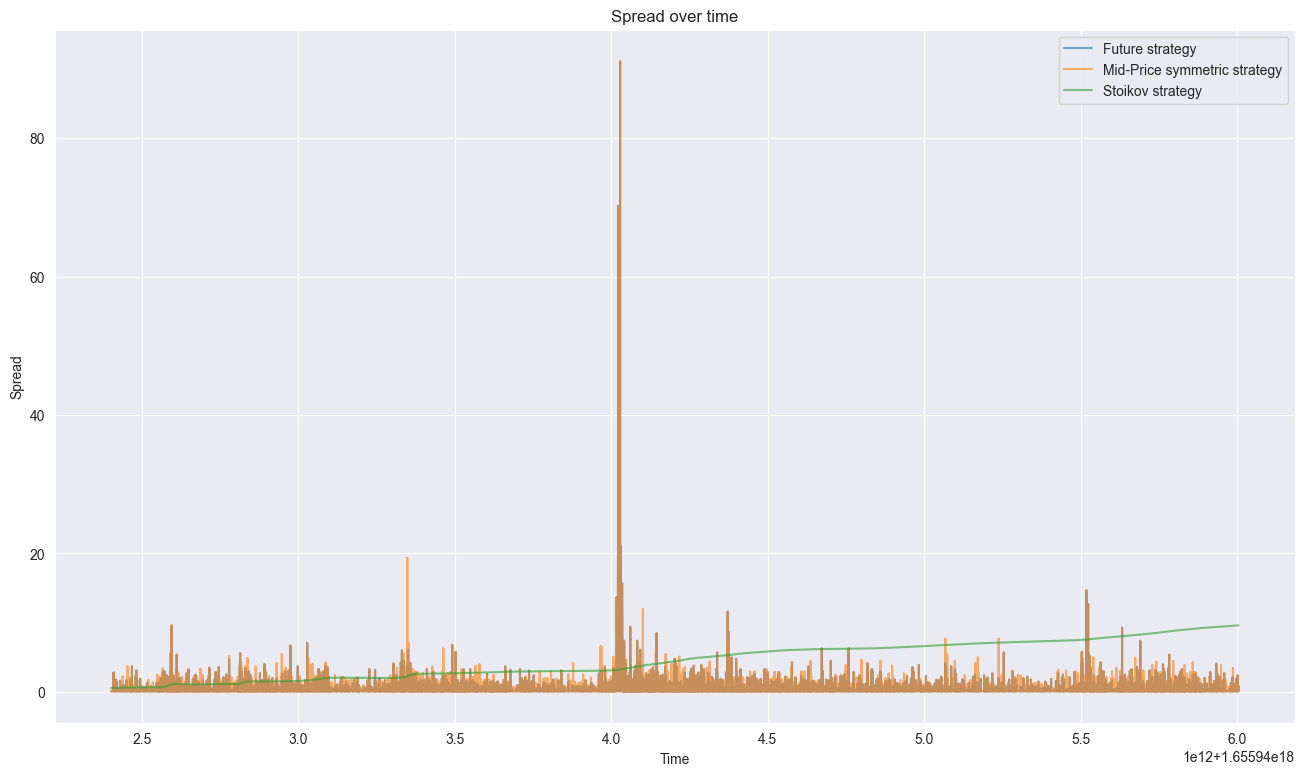

In [43]:
plt.figure(figsize=(16, 9))
plt.title('Spread over time')
plt.plot(future.history['time'], future_spread, label='Future strategy', alpha=0.6)
plt.plot(mid_price.history['time'], mid_spread, label='Mid-Price symmetric strategy',
         alpha=0.6)
plt.plot(stoikov.history['time'], stoikov_spread, label='Stoikov strategy', alpha=0.6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Spread')

Спред у стратегии Стойкова растет с увеличением времени торговли

Сравним inventory стратегий в биткоинах:

Text(0, 0.5, 'PNL')

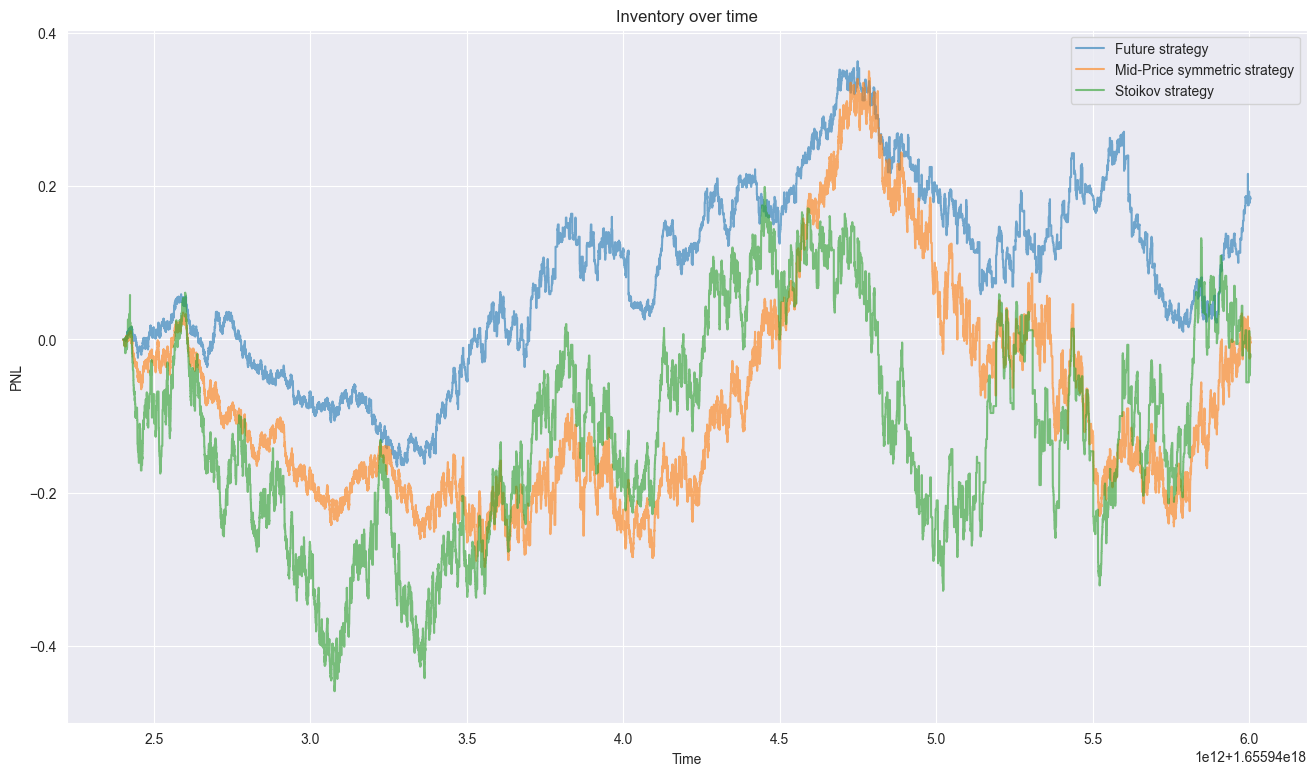

In [44]:
plt.figure(figsize=(16, 9))
plt.title('Inventory over time')
plt.plot(future.history['time'], future.history['inventory'], label='Future strategy', alpha=0.6)
plt.plot(mid_price.history['time'], mid_price.history['inventory'], label='Mid-Price symmetric strategy',
         alpha=0.6)
plt.plot(stoikov.history['time'], stoikov.history['inventory'], label='Stoikov strategy', alpha=0.6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('PNL')

In [47]:
print('Средние значения Inventory:\nStoikov strategy: {}\nMid-Price strategy: {}\nFuture strategy: {}'.format(np.std(stoikov.history['inventory'][1:]), np.std(mid_price.history['inventory'][1:]), np.std(future.history['inventory'][1:])))

Средние значения Inventory:
Stoikov strategy: 0.1508364171483626
Mid-Price strategy: 0.1258555457923663
Future strategy: 0.12080805478007188


Дисперсия размера портфеля у стратегии Стойкова оказалась выше, чем у других стратегий.

Мы получили не совсем ожидаемые результаты, потому что $T - t$ заменено на константу. В оригинальной стратегии при приближении к  $T$ стратегия должна приближаться к симметричной.